In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Resources.Model import Model_v4
from Resources.Game import *
from Resources.TS_ModelGuided_MCRollout import *


In [10]:
gamma = 0.98

error_hist = []
game_count = 0
draw_count = 0

criterion = nn.MSELoss()
model = Model_v4() # Conv large
model.train()
model.load_state_dict(torch.load('../Monte Carlo//Model Saves MC v4/model_36510_games'))
white_wins = 0
black_wins = 0
draws = 0

 -- 0 -- winner: white, i: 115    wins: w = 1, b = 0, d = 0


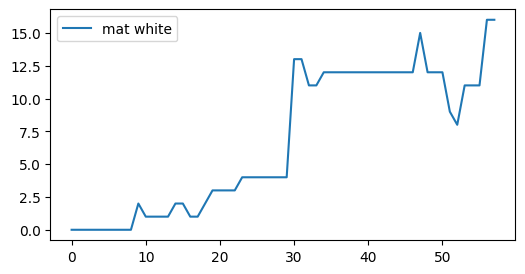

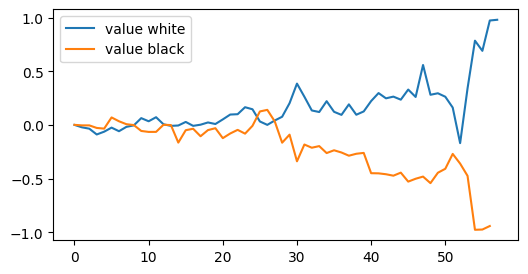

 -- 1 -- winner: white, i: 321    wins: w = 2, b = 0, d = 0


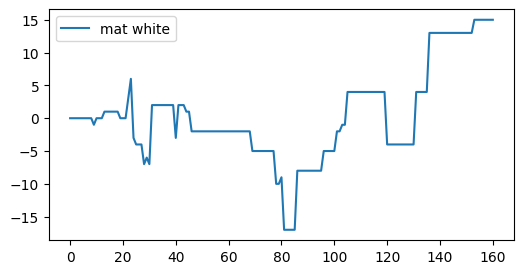

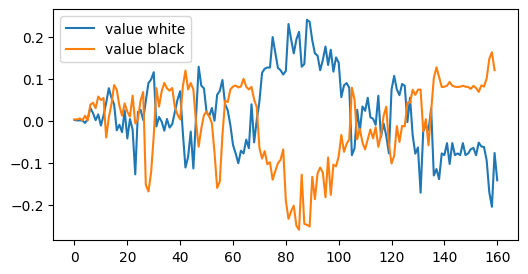

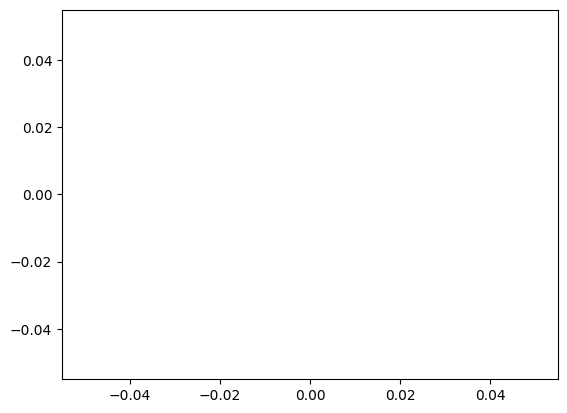

 -- 2 -- winner: black, i: 282    wins: w = 2, b = 1, d = 0


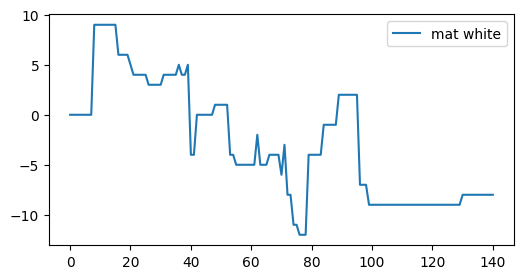

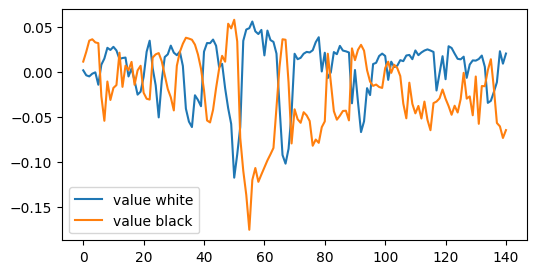

 -- 3 -- winner: black, i: 98    wins: w = 2, b = 2, d = 0


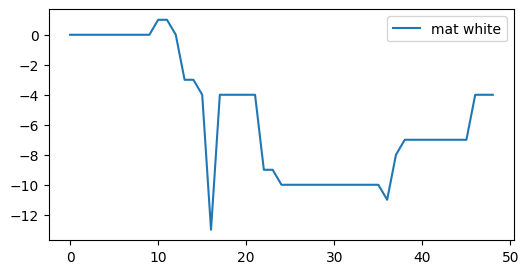

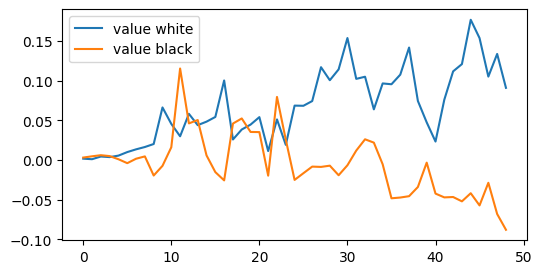

 -- 4 -- winner: white, i: 123    wins: w = 3, b = 2, d = 0


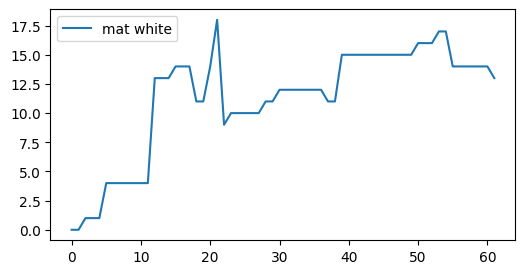

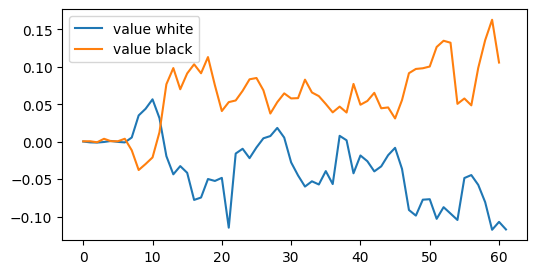

 -- 5 -- winner: black, i: 126    wins: w = 3, b = 3, d = 0


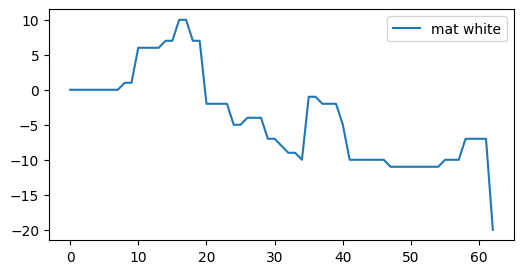

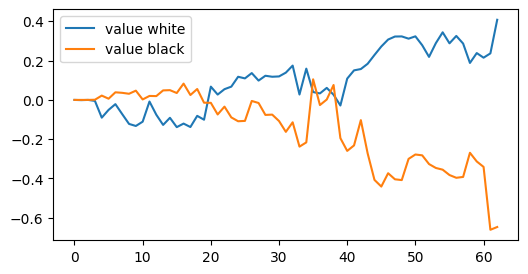

 -- 6 -- winner: white, i: 179    wins: w = 4, b = 3, d = 0


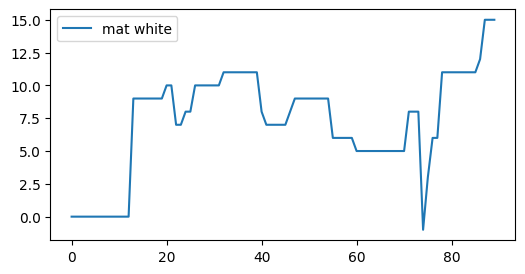

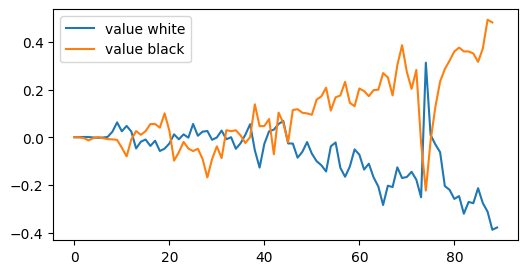

 -- 7 -- winner: white, i: 163    wins: w = 5, b = 3, d = 0


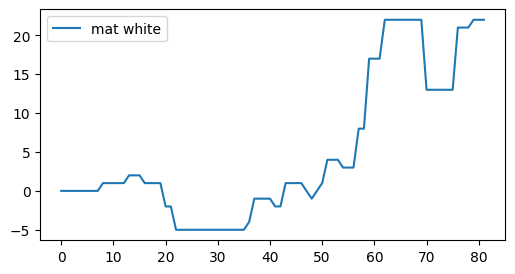

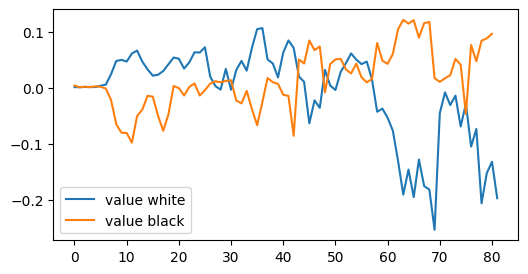

 -- 8 -- winner: black, i: 238    wins: w = 5, b = 4, d = 0


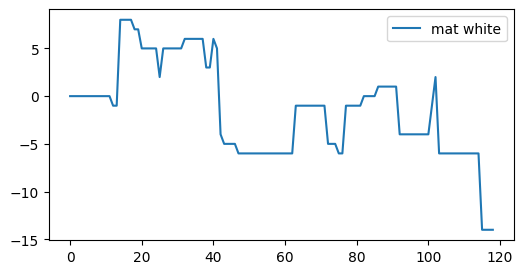

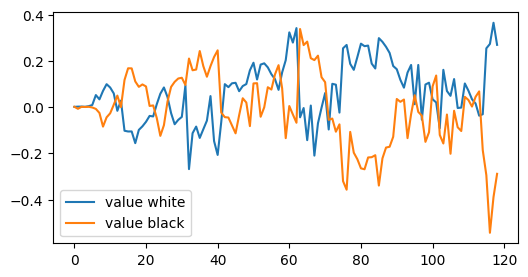

 -- 9 -- winner: black, i: 218    wins: w = 5, b = 5, d = 0


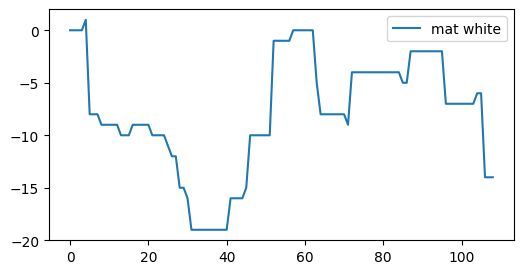

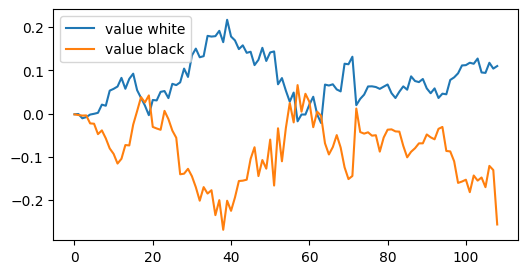

 -- 10 -- winner: black, i: 238    wins: w = 5, b = 6, d = 0


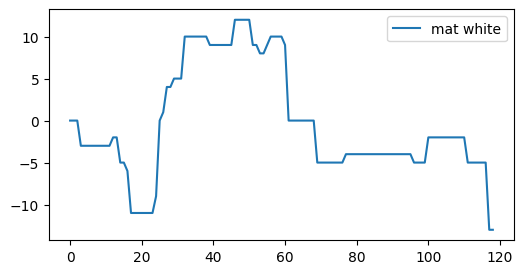

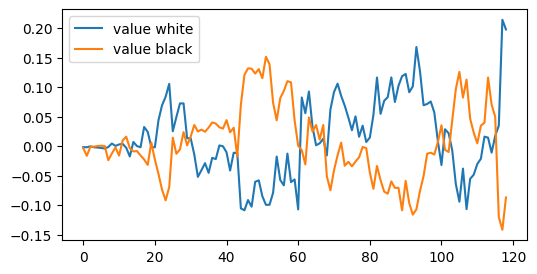

 -- 11 -- winner: white, i: 209    wins: w = 6, b = 6, d = 0


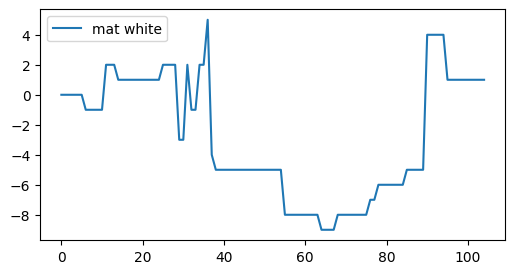

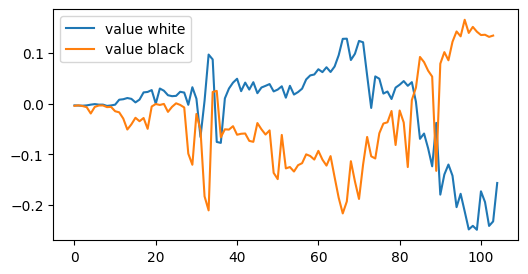

 -- 12 -- winner: white, i: 183    wins: w = 7, b = 6, d = 0


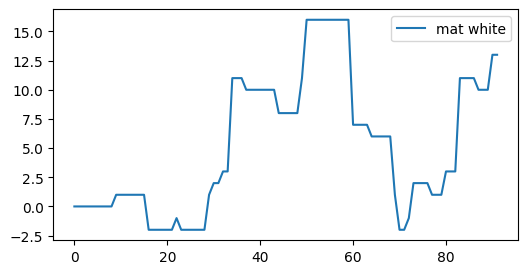

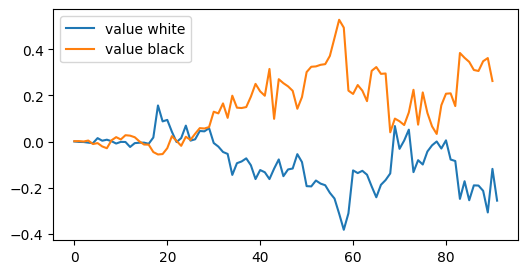

 -- 13 -- winner: white, i: 361    wins: w = 8, b = 6, d = 0


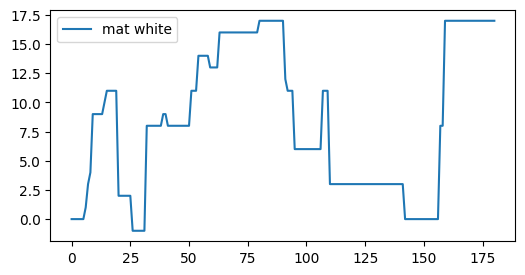

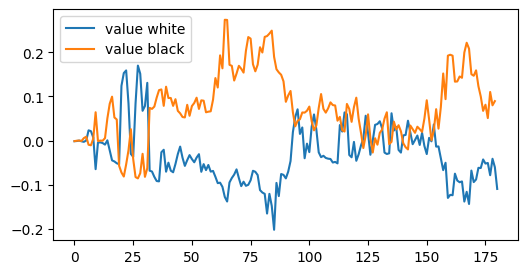

 -- 14 -- winner: white, i: 107    wins: w = 9, b = 6, d = 0


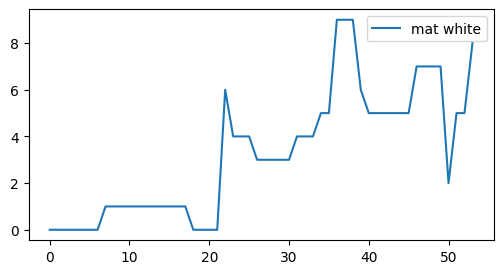

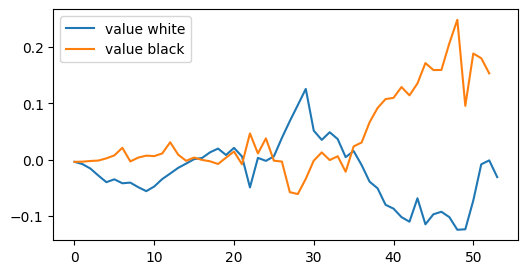

 -- 15 -- winner: white, i: 325    wins: w = 10, b = 6, d = 0


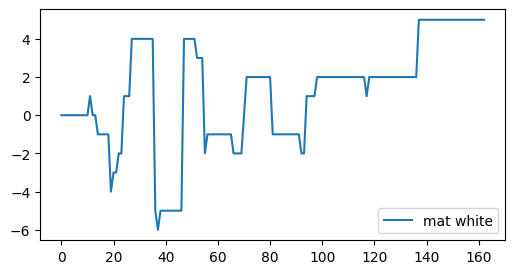

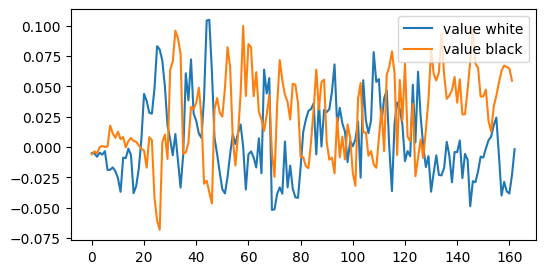

 -- 16 -- winner: black, i: 340    wins: w = 10, b = 7, d = 0


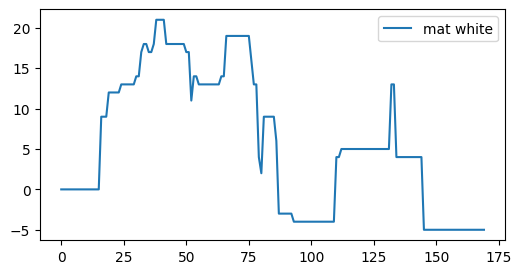

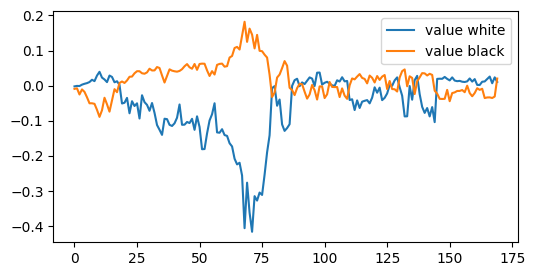

 -- 17 -- winner: white, i: 189    wins: w = 11, b = 7, d = 0


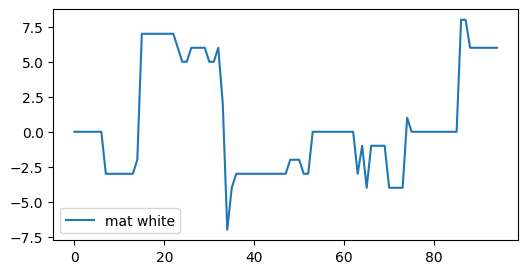

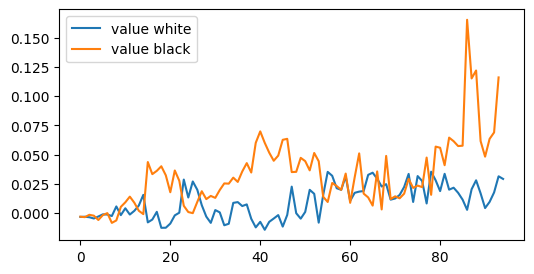

 -- 18 -- winner: black, i: 238    wins: w = 11, b = 8, d = 0


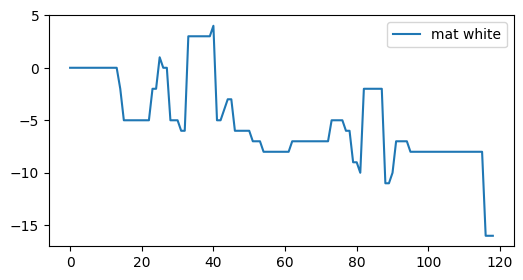

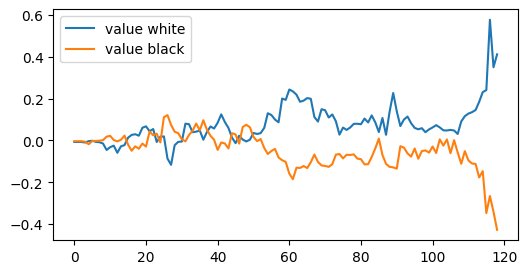

KeyboardInterrupt: 

In [11]:
while True:
    t0 = time.time()

    game = Game()
    next_root = None
    i = 0
    boards_white = [];  boards_black = []
    mat_white = [];     mat_black = []

    boards = []
    labels = []

    model.eval()

    while not game.is_over():
        i += 1

        chosen_move, root = MC_TS(game, model, root=next_root, tmax=10, prints=False, factor_explore=1e-2)
        # print('visits = {}, wins = {}'.format(root.visits, root.wins))

        for child in root.children:
            if child.move == chosen_move:
                next_root = child
                break
        
        game.PlayMove(chosen_move)

        boards.append(board_to_tensor(game.pieces))
        labels.append(root.wins / root.visits)

        mat_diff = game.MaterialDiff()

        if i % 2 == 1:
            boards_white.append(board_to_tensor(game.pieces))
            mat_white.append(mat_diff)
        if i % 2 == 0:
            boards_black.append(board_to_tensor(game.pieces))
            mat_black.append(mat_diff)

        game.FlipBoard()

    winner = game.get_winner()

    values_white = model(torch.stack(boards_white)).detach().numpy()
    values_black = model(torch.stack(boards_black)).detach().numpy()

    game_time = time.time() - t0

    inputs_tens = torch.stack(boards)
    labels_tens = torch.Tensor(labels)   

    if winner != 'draw':
        # newest training error
        out = model(inputs_tens)
        out = out.view(out.shape[0])
        loss = criterion(out, labels_tens)
        error_hist.append(loss.item())
    else:
        draw_count += 1
        continue

    if winner == 'draw':
        draws += 1
    if winner == 'white':
        white_wins += 1
    if winner == 'black':
        black_wins += 1

    if game_count % 10 == 0 or True:
        print(' -- {} -- winner: {}, i: {}   '.format(game_count, winner, i), 'wins: w = {}, b = {}, d = {}'.format(white_wins, black_wins, draws))


    if game_count % 100 == 1 or True:
        plt.figure(figsize=(6, 3))
        plt.plot(mat_white, label='mat white')
        plt.legend()
        plt.show()
        plt.figure(figsize=(6, 3))
        plt.plot(values_white, label='value white')
        plt.plot(values_black, label='value black')
        plt.legend()
        plt.show()

    torch.save(inputs_tens, './Game Saves MCTS v4/inputs_{}'.format(game_count))
    torch.save(labels_tens, './Game Saves MCTS v4/labels_{}'.format(game_count))

    t1 = time.time()

    if game_count > 5:
        # sample some of previous game for replay. More recent -> more likely
        decay_rate = 0.003
        prob =  np.exp(-decay_rate * np.arange(game_count)) 
        prob = prob /sum(prob)
        num_samples = 3
        samples = np.random.choice(np.arange(game_count, 0, -1), size=num_samples, p=prob)

        for indices in samples:
            inputs_load = torch.load('./Game Saves MCTS v4/inputs_{}'.format(indices))
            inputs_tens = torch.cat((inputs_load, inputs_tens))
            labels_tens = torch.cat((torch.load('./Game Saves MCTS v4/labels_{}'.format(indices)), labels_tens))

    len_boards = len(inputs_tens)
    for c in range(len_boards):
        tens = inputs_tens[c]
        # if no pawns are on the board: add all other 3 rotated versions of the board to the current data set
        if torch.sum(inputs_tens[c][0]) + torch.sum(inputs_tens[c][6]) == 0:
            board_new = tensor_to_board(tens)
            for _ in range(3):
                board_new = rotate_board(board_new, 1)
                tens_new = torch.stack([board_to_tensor(board_new)])
                inputs_tens = torch.cat((inputs_tens, tens_new), 0)
                labels_tens = torch.cat((labels_tens, torch.stack([labels_tens[c]])), 0)
    
    model.train()
    # learning_rate = 5e-4 * 500 / (500 + game_count) # reducing learning rate, 1/n one possible options
    learning_rate = 1e-4
    # weight_decay = 1e-2 # regularization to avoid overfitting
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    random_order = [i for i in range(len(inputs_tens))]
    np.random.shuffle(random_order)
    for c in random_order:

        inp = torch.stack([inputs_tens[c], mirror_board_tensor(inputs_tens[c])])
        label = torch.stack([labels_tens[c], labels_tens[c]])

        out = model(inp)
        out = out.view(out.shape[0])

        loss = criterion(out, label)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    torch.save(error_hist, './error_hist MCTS v4')

    if game_count % 100  == 1:
        interval = 50
        plt.figure()
        plt.plot([np.mean(error_hist[i:i+interval]) for i in range(len(error_hist) - interval)])
        plt.show()

    if game_count % 100 == 9 or True:    
        torch.save(model.state_dict(), './Model Saves MCTS v4/model_{}_games'.format(game_count+1))

    game_count += 1
